<a href="https://colab.research.google.com/github/sam134-eng/INM706-Sequence-analysis/blob/main/LSTM_Model_for_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Download NLTK data unconditionally at the start
# This ensures 'punkt', 'stopwords', and 'punkt_tab' are available for text processing
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
# Download punkt_tab resource explicitly as it seems to be required by word_tokenize in this context
nltk.download('punkt_tab', quiet=True)

# --- Download and extract GloVe embeddings ---
# This is necessary to load pre-trained word vectors later in the script.
# The file glove.6B.100d.txt is expected by the load_glove function.

# Download the GloVe 6B dataset (contains embeddings of different dimensions)
# This command downloads the zip file from the Stanford NLP website.
# It's a large file, so it may take some time depending on your internet connection.
!wget http://nlp.stanford.edu/data/glove.6B.zip

# Unzip the downloaded file
# This extracts all files within the zip, including glove.6B.100d.txt,
# into your current working directory.
!unzip -o glove.6B.zip # -o option overwrites existing files without prompting


# --- 1. Load and Preprocess Data ---
# Assuming 'Tweets.csv' is available in the environment.
# In a Colab environment, you would typically upload it first.
# For this self-contained code, we'll assume it's loaded.
# If running locally, ensure 'Tweets.csv' is in the same directory.
try:
    df = pd.read_csv("Tweets.csv")
except FileNotFoundError:
    print("Error: 'Tweets.csv' not found. Please ensure the file is uploaded or in the correct directory.")
    # Create a dummy DataFrame for demonstration if file is not found
    # Modified dummy data to have at least two examples per class for stratified split
    data = {
        'text': [
            "@VirginAmerica What @dhepburn said.", # Neutral
            "@VirginAmerica plus you've added commercials to the experience... #fail", # Negative
            "@VirginAmerica I didn't today... Must mean I need to fly it again!", # Positive
            "@VirginAmerica it's really aggressive to blast obnoxious "
            "loud commercials into little earbuds. #anditshardtohearanyone", # Negative
            "@VirginAmerica and it's a really big bad thing about it", # Negative
            "This is a great flight, excellent service!", # Positive
            "Everything was just okay, nothing to write home about.", # Neutral
            "My bags were lost, terrible experience.", # Negative
            "Loved the onboard entertainment.", # Positive
            "The food was decent.", # Neutral
            "Worst flight of my life, never flying again." # Negative
        ],
        'airline_sentiment': ['neutral', 'negative', 'positive', 'negative', 'negative', 'positive', 'neutral', 'negative', 'positive', 'neutral', 'negative']
    }
    df = pd.DataFrame(data)
    print("Using a dummy DataFrame with more data for demonstration.")


# Keep only relevant columns: 'text' and 'airline_sentiment'
df = df[['text', 'airline_sentiment']]

# Filter to ensure only 'positive', 'neutral', 'negative' sentiments are included
df = df[df['airline_sentiment'].isin(['positive', 'neutral', 'negative'])]

# Map sentiment labels to integers for model training
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['airline_sentiment'].map(label_map)

# Define stopwords for text cleaning
stop_words = set(stopwords.words('english'))

# Function to clean and tokenize text
def clean_text(text):
    """
    Cleans the input text by:
    - Removing URLs, mentions (@), hashtags (#)
    - Removing non-alphabetic characters
    - Converting to lowercase
    - Tokenizing the text
    - Removing stopwords
    """
    text = re.sub(r"http\S+|@\w+|#\w+|[^a-zA-Z\s]", "", text.lower())
    tokens = word_tokenize(text)
    return " ".join([t for t in tokens if t not in stop_words]) # Join tokens back to string for TF-IDF/Tokenizer

# Apply the cleaning function to the 'text' column
df['clean_text'] = df['text'].apply(clean_text)

# --- 2. Prepare Data for LSTM ---
# Define features (X) and labels (y)
X = df['clean_text']
y = df['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Initialize Keras Tokenizer
# num_words: the maximum number of words to keep, based on word frequency.
# oov_token: token to represent out-of-vocabulary words.
tokenizer = Tokenizer(num_words=5000, oov_token="<UNK>")
tokenizer.fit_on_texts(X_train) # Fit tokenizer only on training data

# Convert text sequences to integer sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform input length for the LSTM layer
# maxlen: maximum length of all sequences. Sequences longer than this are truncated,
# and sequences shorter are padded.
maxlen = 50 # Example max length, can be tuned
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen)

# Convert labels to numpy arrays
y_train_np = np.array(y_train)
y_test_np = np.array(y_test)

# --- 3. Load Pre-trained Word Embeddings (GloVe) ---
# This function assumes 'glove.6B.100d.txt' is available.
# You would typically download this file (e.g., from Stanford's GloVe page)
# and place it in your working directory.
def load_glove(tokenizer, embedding_dim=100):
    """
    Loads pre-trained GloVe word embeddings and creates an embedding matrix
    for the words in the tokenizer's vocabulary.

    Args:
        tokenizer: Keras Tokenizer object, fitted on the text data.
        embedding_dim (int): Dimension of the GloVe embeddings (e.g., 50, 100, 200, 300).

    Returns:
        numpy.ndarray: Embedding matrix where each row corresponds to a word
                       in the tokenizer's vocabulary and its pre-trained embedding vector.
    """
    embeddings_index = {}
    glove_file_path = f"glove.6B.{embedding_dim}d.txt"
    try:
        with open(glove_file_path, encoding='utf8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                vector = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = vector
    except FileNotFoundError:
        print(f"Error: {glove_file_path} not found.")
        print("Please download GloVe embeddings (e.g., glove.6B.zip from Stanford)")
        print("and extract the appropriate file into the working directory.")
        return None # Return None if file is not found

    word_index = tokenizer.word_index
    num_words = min(tokenizer.num_words, len(word_index) + 1) # Number of words in tokenizer vocab
    embedding_matrix = np.zeros((num_words, embedding_dim))

    for word, i in word_index.items():
        if i >= num_words:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector

    print(f"Found {len(embeddings_index)} word vectors in GloVe.")
    print(f"Created embedding matrix of shape: {embedding_matrix.shape}")
    return embedding_matrix

# Load the GloVe embedding matrix
embedding_dim = 100 # Match the dimension of the GloVe file you intend to use
embedding_matrix = load_glove(tokenizer, embedding_dim)

# --- 4. Build the LSTM Model ---
# Only build the model if embedding_matrix was successfully loaded
if embedding_matrix is not None:
    vocab_size = min(tokenizer.num_words, len(tokenizer.word_index) + 1) # Vocabulary size
    num_classes = len(label_map) # Number of sentiment classes (3: negative, neutral, positive)

    model = Sequential([
        # Embedding layer using pre-trained GloVe weights
        # input_dim: vocabulary size
        # output_dim: dimension of the dense embedding (same as embedding_dim)
        # input_length: length of input sequences (maxlen)
        # weights: pre-trained weights from GloVe
        # trainable: set to False to keep embeddings fixed, True to fine-tune them
        Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  input_length=maxlen,
                  weights=[embedding_matrix],
                  trainable=False), # Set to True to fine-tune embeddings
        LSTM(units=128, return_sequences=False), # LSTM layer, return_sequences=False for classification
        Dropout(0.5), # Dropout for regularization
        Dense(units=64, activation='relu'), # Dense layer
        Dropout(0.5), # Dropout for regularization
        Dense(units=num_classes, activation='softmax') # Output layer with softmax for multi-class classification
    ])

    # Compile the model
    # optimizer: e.g., 'adam', 'rmsprop'
    # loss: 'sparse_categorical_crossentropy' for integer labels
    # metrics: 'accuracy' to monitor performance
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Print model summary
    model.summary()

    # --- 5. Train the Model ---
    epochs = 5 # Number of training epochs, can be tuned
    batch_size = 32 # Batch size, can be tuned

    # Check if training data is sufficient
    if len(X_train_pad) > 0:
        history = model.fit(X_train_pad, y_train_np,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_split=0.2) # Use 20% of training data for validation
    else:
        print("Not enough training data to fit the model.")
else:
    print("Model training skipped because GloVe embedding matrix was not loaded.")

# --- 6. Evaluate the Model (if trained) ---
if 'model' in locals() and len(X_test_pad) > 0:
    print("\nEvaluating the model on the test set...")
    loss, accuracy = model.evaluate(X_test_pad, y_test_np, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
elif 'model' not in locals():
     print("\nModel was not built, skipping evaluation.")
else:
    print("\nNot enough test data to evaluate the model.")


# --- 7. Make Predictions (Optional) ---
if 'model' in locals():
    print("\nMaking predictions on the test set...")
    predictions = model.predict(X_test_pad)
    predicted_classes = np.argmax(predictions, axis=1)

    # Map integer predictions back to sentiment labels
    reverse_label_map = {v: k for k, v in label_map.items()}
    predicted_sentiments = [reverse_label_map[pred] for pred in predicted_classes]

    # Display some sample predictions
    print("Sample Predictions:")
    for i in range(min(10, len(X_test))): # Display first 10 predictions
        original_text = df.iloc[X_test.index[i]]['text'] # Get original text from the original df
        actual_sentiment = df.iloc[X_test.index[i]]['airline_sentiment'] # Get actual sentiment
        print(f"  Text: {original_text}")
        print(f"  Actual Sentiment: {actual_sentiment}")
        print(f"  Predicted Sentiment: {predicted_sentiments[i]}")
        print("-" * 20)
else:
    print("\nSkipping prediction as the model was not built or trained.")

# --- Example of predicting on a new sentence ---
if 'model' in locals() and 'tokenizer' in locals() and maxlen is not None:
    def predict_sentiment(text, model, tokenizer, maxlen, label_map):
        """
        Predicts the sentiment of a single new text input.

        Args:
            text (str): The input text string.
            model: The trained Keras model.
            tokenizer: The fitted Keras Tokenizer.
            maxlen (int): The maximum sequence length used during training.
            label_map (dict): Dictionary mapping sentiment strings to integers.

        Returns:
            str: The predicted sentiment label ('negative', 'neutral', 'positive').
        """
        # Clean the text
        cleaned_text = clean_text(text)
        # Convert to sequence
        seq = tokenizer.texts_to_sequences([cleaned_text])
        # Pad the sequence
        padded_seq = pad_sequences(seq, maxlen=maxlen)
        # Make prediction
        prediction = model.predict(padded_seq)[0]
        # Get the predicted class index
        predicted_class_index = np.argmax(prediction)
        # Map index back to label
        reverse_label_map = {v: k for k, v in label_map.items()}
        predicted_sentiment = reverse_label_map[predicted_class_index]
        return predicted_sentiment

    # Example usage
    new_sentence1 = "The flight was delayed, but the staff was helpful."
    predicted_sentiment1 = predict_sentiment(new_sentence1, model, tokenizer, maxlen, label_map)
    print(f"\nSentiment for '{new_sentence1}': {predicted_sentiment1}")

    new_sentence2 = "Absolutely loved the movie!"
    predicted_sentiment2 = predict_sentiment(new_sentence2, model, tokenizer, maxlen, label_map)
    print(f"Sentiment for '{new_sentence2}': {predicted_sentiment2}")

    new_sentence3 = "This is just an average experience."
    predicted_sentiment3 = predict_sentiment(new_sentence3, model, tokenizer, maxlen, label_map)
    print(f"Sentiment for '{new_sentence3}': {predicted_sentiment3}")

    new_sentence4 = "Terrible customer service."
    predicted_sentiment4 = predict_sentiment(new_sentence4, model, tokenizer, maxlen, label_map)
    print(f"Sentiment for '{new_sentence4}': {predicted_sentiment4}")

else:
    print("\nSkipping prediction on new sentences as model or tokenizer is not available.")

--2025-05-23 12:40:39--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-23 12:40:39--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-23 12:40:40--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 500,000 (1.91 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 500,000 (1.91 MB)

Epoch 1/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 30s 91ms/step - accuracy: 0.6749 - loss: 0.7917 - val_accuracy: 0.7392 - val_loss: 0.6399
Epoch 2/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step - accuracy: 0.7441 - loss: 0.6411 - val_accuracy: 0.7636 - val_loss: 0.5896
Epoch 3/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 40s 77ms/step - accuracy: 0.7573 - loss: 0.5893 - val_accuracy: 0.7665 - val_loss: 0.5744
Epoch 4/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 42s 80ms/step - accuracy: 0.7815 - loss: 0.5524 - val_accuracy: 0.7678 - val_loss: 0.5788
Epoch 5/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.7761 - loss: 0.5496 - val_accuracy: 0.7789 - val_loss: 0.5518

Evaluating the model on the test set...
Test Loss: 0.5651
Test Accuracy: 0.7705

Making predictions on the test set...
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
Sample Predictions:
  Text: @united past
  Actual Sentiment: neutral
  Predicted Sentiment: neutral
--------------------
  Text: @JetBlue would you say a delay is more likely? Thanks so much.
  A


Generating Accuracy/Loss Plots...


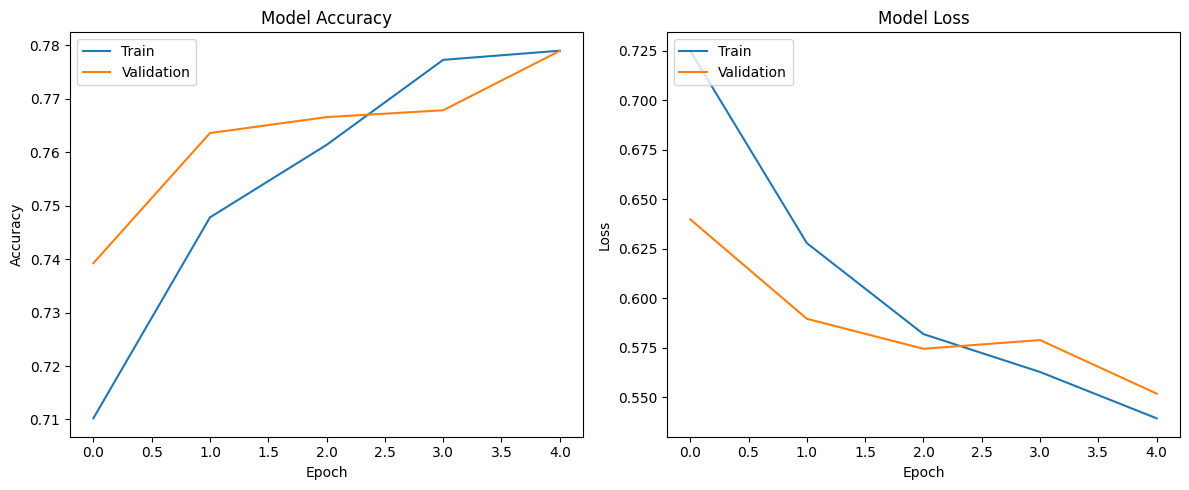


Generating Classification Report and Confusion Matrix...

Classification Report:
              precision    recall  f1-score   support

    negative       0.83      0.87      0.85      1835
     neutral       0.62      0.54      0.58       620
    positive       0.70      0.67      0.68       473

    accuracy                           0.77      2928
   macro avg       0.72      0.70      0.70      2928
weighted avg       0.76      0.77      0.77      2928



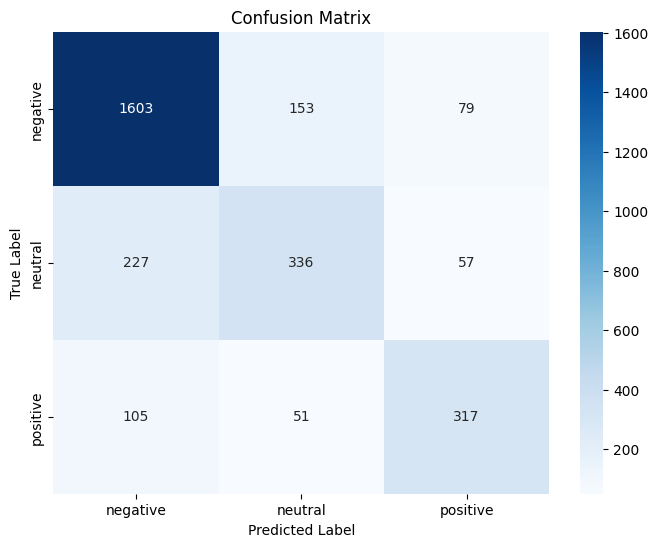

In [8]:
# prompt: generate accuracy/loss plots
# generate classification report
# generate confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- Generate Accuracy/Loss Plots (if history object exists) ---
if 'history' in locals() and history is not None:
    print("\nGenerating Accuracy/Loss Plots...")
    # Plot training and validation accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()
elif 'history' in locals():
    print("\nHistory object is None, skipping accuracy/loss plots.")
else:
    print("\nHistory object not found (model likely not trained), skipping accuracy/loss plots.")


# --- Generate Classification Report and Confusion Matrix (if model was evaluated) ---
if 'model' in locals() and len(X_test_pad) > 0:
    print("\nGenerating Classification Report and Confusion Matrix...")

    # Get true labels
    true_classes = y_test_np

    # Get predicted classes from evaluation step
    # predictions = model.predict(X_test_pad) # Predictions were already made above
    # predicted_classes = np.argmax(predictions, axis=1) # Predicted classes were already derived

    # Ensure predicted_classes and true_classes have the same length
    if len(true_classes) == len(predicted_classes):
        # Generate classification report
        target_names = [reverse_label_map[i] for i in sorted(reverse_label_map.keys())]
        print("\nClassification Report:")
        print(classification_report(true_classes, predicted_classes, target_names=target_names))

        # Generate confusion matrix
        cm = confusion_matrix(true_classes, predicted_classes)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()
    else:
        print("Mismatch between true labels and predicted labels length, skipping classification report and confusion matrix.")

elif 'model' not in locals():
     print("\nModel was not built, skipping classification report and confusion matrix.")
else:
    print("\nNot enough test data or predictions not available, skipping classification report and confusion matrix.")